## モジュール、データの読み込み

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot  as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
# XGboost
import xgboost as xgb
from xgboost import XGBClassifier
import warnings

In [2]:
# 表示関連
## DataFrameの列数設定
pd.set_option('display.max_columns', 500)
## warningの抑制
warnings.filterwarnings('ignore')

In [3]:
df_stock = pd.read_csv('stock_2018.csv')

In [4]:
df_stock.head()

,value_date,stock_code,open,close,HIGH,LOW,VOLUME
0,2018-01-04,1301,4270,4320,4335,4220,61500
1,2018-01-05,1301,4330,4340,4360,4285,55300
2,2018-01-09,1301,4340,4340,4360,4325,26100
3,2018-01-10,1301,4340,4430,4460,4340,91300
4,2018-01-11,1301,4430,4350,4430,4340,48200


In [5]:
# 欠損値がないかを見ています。
df_stock.isnull().sum()

value_date    0
stock_code    0
open          0
close         0
HIGH          0
LOW           0
VOLUME        0
dtype: int64

In [6]:
stock_codes = df_stock['stock_code'].unique()

# 銘柄の選定

#### 1、まず2018年度の株価の終値のデータを使って、線形回帰を行い、直線の傾きが正で決定係数が0.6以上のものを取り出しています。

In [7]:
stock_codes_select = []
from sklearn.linear_model import LinearRegression
for stock_code in stock_codes:
    df_stock_target = df_stock[(df_stock['stock_code'] == stock_code)]
    data_date = pd.to_datetime(df_stock_target["value_date"])
    data_close = df_stock_target["close"]
    
    data_num_df = pd.DataFrame(list(range(0, df_stock_target.shape[0])))
    data_close_df = df_stock_target[["close"]] # これでdataframe型となる
    
    model = LinearRegression() # モデルを作成
    model.fit(data_num_df, data_close_df) # 学習
    py = model.predict(data_num_df)
    
    r2 = model.score(data_num_df, data_close_df) # 決定係数
    if (r2 >= 0.6) & (model.coef_ > 0):
        stock_codes_select.append(stock_code)

In [8]:
len(stock_codes_select)

189

In [9]:
# 株価をプロットするための関数です。
def plot_stock(stock_code):
    df_stock_target = df_stock[df_stock['stock_code'] == stock_code]
    data_date = pd.to_datetime(df_stock_target["value_date"])
    data_close = df_stock_target["close"]
    data_num_df = pd.DataFrame(list(range(0,df_stock_target.shape[0])))
    
    data_close_df = df_stock_target[["close"]] # これでdataframe型となる
    
    model = LinearRegression() # モデルを作成
    model.fit(data_num_df, data_close_df) # 学習
    py = model.predict(data_num_df)
    
    plt.plot(data_date,data_close,label="Acctual")
    plt.plot(data_date,py,label="LinearRegression",lw=5)
    plt.legend()
    plt.xlabel("Day")
    plt.ylabel("Yen")
    plt.show()

In [10]:
stock_codes_select[:5]

[1343, 1345, 1398, 1407, 1476]

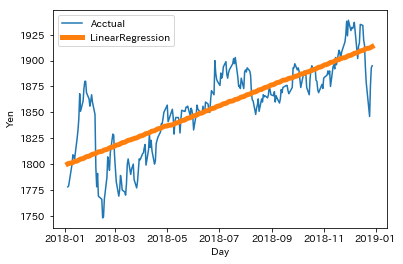

In [11]:
# 試しに図示しています。
plot_stock(1343)

#### 2、次に、決算期が12月と1月の企業を選んできます。<br>

決算期が12月と1月の企業は決算発表が2月から3月にかけてなので、これを基準にしました。

In [12]:
# 12月が決算の企業の証券コードです。
kessan12_stock = [2408,
6172,
3091,
3912,
6866,
6858,
7739,
8060,
2491,
3003,
3064,
4779,
5819,
6663,
7751,
2811,
3630,
4248,
4284,
4519,
4967,
5008,
6553,
6817,
2675,
3765,
4107,
4563,
5015,
7422,
4768,
4452,
4746,
7177,
9768,
2268,
3436,
3744,
4151,
4356,
5214,
6269,
8804,
8929,
3633,
3947,
4551,
4722,
5201,
5816,
6769,
9543,
9757,
2009,
2216,
2389,
2914,
3261,
3998,
4312,
4582,
4641,
4784,
6029,
6722,
7172,
7609,
7716,
7989,
9830,
1429,
1897,
1994,
2193,
2266,
2461,
2533,
2777,
3085,
3482,
3566,
3671,
3695,
3782,
3852,
3948,
3950,
3961,
3997,
4321,
4351,
4572,
4579,
4588,
4642,
4812,
4848,
4911,
4955,
5302,
5563,
5946,
6026,
6077,
6079,
6180,
6268,
6411,
6537,
6546,
6560,
6573,
6640,
6653,
6853,
6929,
7833,
8165,
8892,
9384,
9416,
9622,
4428,
7043,
9656,
1439,
1663,
2124,
2429,
2436,
2702,
3241,
3276,
3299,
3319,
3540,
3659,
3776,
3777,
3788,
3902,
4025,
4221,
4565,
4595,
4755,
5301,
6141,
6164,
6266,
6440,
6856,
6985,
7037,
7272,
7309,
7587,
7625,
7740,
7816,
7849,
7963,
7984,
8854,
9441,
9449,
9827,
1400,
1435,
1718,
1724,
1899,
2150,
2169,
2311,
2384,
2501,
2743,
2970,
3138,
3204,
3355,
3405,
3416,
3445,
3486,
3623,
3664,
3667,
3681,
3683,
3719,
3784,
3901,
3940,
3966,
3968,
3983,
4045,
4189,
4395,
4404,
4420,
4463,
4593,
4596,
4597,
4612,
4772,
4776,
4912,
4919,
4927,
4963,
4971,
4985,
5110,
5187,
5704,
5851,
5943,
5950,
5957,
5997,
6063,
6099,
6171,
6235,
6250,
6310,
6328,
6361,
6465,
6633,
6870,
7036,
7190,
7228,
7314,
7613,
7718,
7814,
7846,
7936,
7972,
9271,
9386,
9731,
9755,
2160,
2170,
2174,
2195,
2212,
2215,
2402,
2427,
2492,
2502,
2503,
2579,
2587,
2703,
2752,
3053,
3054,
3105,
3197,
3277,
3302,
3350,
3386,
3452,
3474,
3649,
3673,
3675,
3688,
3775,
3904,
3909,
3911,
3928,
3964,
3975,
3981,
4004,
4186,
4235,
4245,
4286,
4324,
4392,
4576,
4583,
4585,
4631,
4633,
4634,
4725,
4979,
5010,
5101,
5184,
5216,
5310,
5337,
5610,
5699,
5959,
6054,
6067,
6071,
6078,
6143,
6149,
6177,
6265,
6326,
6376,
6400,
6425,
6459,
6464,
6481,
6533,
6540,
6561,
6592,
6619,
6627,
6694,
6789,
6835,
6914,
6915,
6977,
7038,
7039,
7044,
7048,
7425,
7782,
7841,
7915,
7957,
7992,
8011,
8040,
8090,
8113,
8179,
8186,
8885,
8914,
9260,
9539,
9612,
9621,
9672,
9702,
9749,
2191,
2693,
2700,
2788,
3196,
3663,
3680,
3758,
3906,
4669,
4766,
4840,
5105,
5108,
6291,
6497,
7531,
7776,
7976,
8909,
8946,
2721,
1413,
1449,
2211,
2325,
2330,
2345,
2406,
2418,
2499,
2573,
2597,
3001,
3040,
3047,
3610,
3656,
3693,
3696,
3727,
3807,
3913,
3914,
3938,
4578,
4586,
4704,
5395,
5542,
6081,
6278,
6295,
6557,
6635,
6723,
7170,
7244,
7986,
8029,
8202,
8594,
8996,
9173,
9176,
9419,
9631,
9704,
9722,
9758,
9973]

In [13]:
# 先ほど選んだ企業との共通部分に当たる企業の数です。
len(list(set(stock_codes_select) & set(kessan12_stock)))

31

In [14]:
# 1月が決算の企業の証券コードです。
kessan1_stock = [
7590,
2590,
8068,
4369,
4813,
2217,
3070,
7865,
7956,
6654,
9829,
8842,
9632,
1433,
1928,
2163,
3071,
3657,
4238,
4334,
6757,
6898,
7878,
9734,
9743,
3246,
6966,
7196,
3399,
3955,
6696,
8142,
9636,
9692,
1758,
3169,
3565,
7614,
9681,
3159,
3921,
3995,
4764,
6184,
6336,
8013,
2776,
3320,
3665,
3931,
4287,
4380,
4592,
9637
]

In [15]:
# 12月と1月に決算がある企業群です。
kessan12_1stock = list(set(kessan1_stock) | set(kessan12_stock))

In [16]:
# その数です。
len(kessan12_1stock)

487

In [17]:
# 1、で選んだ企業と2月と1月に決算がある企業の共通部分を取っています。
stock_select = list(set(stock_codes_select) & set(kessan12_1stock))

In [18]:
stock_select

[4107,
 2700,
 2573,
 6411,
 3983,
 9612,
 5395,
 9749,
 4634,
 8090,
 9631,
 4519,
 7849,
 7986,
 6067,
 3906,
 9539,
 5704,
 9416,
 3788,
 3665,
 6099,
 9173,
 1758,
 9829,
 8040,
 1897,
 5610,
 2160,
 4722,
 4221,
 6265,
 3197,
 7422]

In [19]:
# その数です。
len(stock_select)

34

#### 3、次に、2018年のデータと2019年のデータを縦に繋げます。

In [20]:
# 2018年のものです。
df2018 = pd.read_csv('stock_2018.csv')
df2018.head()

,value_date,stock_code,open,close,HIGH,LOW,VOLUME
0,2018-01-04,1301,4270,4320,4335,4220,61500
1,2018-01-05,1301,4330,4340,4360,4285,55300
2,2018-01-09,1301,4340,4340,4360,4325,26100
3,2018-01-10,1301,4340,4430,4460,4340,91300
4,2018-01-11,1301,4430,4350,4430,4340,48200


In [21]:
# 2019年のものです。
df2019 = pd.read_csv('stock_2019.csv')
df2019.head()

,STOCK_CODE,VALUE_DATE,OPEN,CLOSE,HIGH,LOW,VOLUME,ADJ_CLOSE
0,1301,2019-01-04,2806,2852,2861,2760,26200,2852
1,1301,2019-01-07,2890,2859,2937,2843,35400,2859
2,1301,2019-01-08,2866,2867,2901,2861,19900,2867
3,1301,2019-01-09,2900,2919,2942,2898,15800,2919
4,1301,2019-01-10,2910,2901,2933,2875,14200,2901


In [22]:
# 縦に組み合わせるためにカラムの名前を統一します。
df2018 = df2018.rename(columns={'value_date': 'Date', 'open': 'Open', 'close': 'Close', 'HIGH': 'High', 'LOW': 'Low', 'VOLUME': 'Volume'})
df2018.head()

,Date,stock_code,Open,Close,High,Low,Volume
0,2018-01-04,1301,4270,4320,4335,4220,61500
1,2018-01-05,1301,4330,4340,4360,4285,55300
2,2018-01-09,1301,4340,4340,4360,4325,26100
3,2018-01-10,1301,4340,4430,4460,4340,91300
4,2018-01-11,1301,4430,4350,4430,4340,48200


In [23]:
df2019 = df2019.rename(columns={'STOCK_CODE': 'stock_code', 'VALUE_DATE': 'Date', 'OPEN': 'Open', 'CLOSE': 'Close', 'HIGH': 'High', 'LOW': 'Low', 'VOLUME': 'Volume'})
df2019.head()

,stock_code,Date,Open,Close,High,Low,Volume,ADJ_CLOSE
0,1301,2019-01-04,2806,2852,2861,2760,26200,2852
1,1301,2019-01-07,2890,2859,2937,2843,35400,2859
2,1301,2019-01-08,2866,2867,2901,2861,19900,2867
3,1301,2019-01-09,2900,2919,2942,2898,15800,2919
4,1301,2019-01-10,2910,2901,2933,2875,14200,2901


In [24]:
# 合わせるためにADJ_CLOSEを削除します。
df2019.drop('ADJ_CLOSE', axis=1, inplace=True)

In [25]:
df2019.head()

,stock_code,Date,Open,Close,High,Low,Volume
0,1301,2019-01-04,2806,2852,2861,2760,26200
1,1301,2019-01-07,2890,2859,2937,2843,35400
2,1301,2019-01-08,2866,2867,2901,2861,19900
3,1301,2019-01-09,2900,2919,2942,2898,15800
4,1301,2019-01-10,2910,2901,2933,2875,14200


In [26]:
# 繋げます。
df1819 = pd.concat([df2018, df2019])
df1819.head()

,Close,Date,High,Low,Open,Volume,stock_code
0,4320,2018-01-04,4335,4220,4270,61500,1301
1,4340,2018-01-05,4360,4285,4330,55300,1301
2,4340,2018-01-09,4360,4325,4340,26100,1301
3,4430,2018-01-10,4460,4340,4340,91300,1301
4,4350,2018-01-11,4430,4340,4430,48200,1301


In [27]:
df1819.tail()

,Close,Date,High,Low,Open,Volume,stock_code
91725,882,2019-02-01,924,880,892,802700,9997
91726,885,2019-02-04,905,872,875,413700,9997
91727,874,2019-02-05,901,866,900,547100,9997
91728,901,2019-02-06,904,873,877,438500,9997
91729,866,2019-02-07,898,863,896,493800,9997


#### 4、いただいたデータにプラスして、quandlからデータを取ります。
#### また、quandlのデータは2017年までのデータなので、先ほどのデータ(2018、2019年の株価)を繋げます。

In [28]:
import quandl
import pandas as pd
import  matplotlib.pyplot as plt

quandl.ApiConfig.api_key = 'AkjU48wE8BiZr3i7Eomu'
for stock_code in stock_select:
    quandl_data = quandl.get("TSE/{}".format(stock_code))
    quandl_data.to_csv('./data/df{}.csv'.format(stock_code))

In [29]:
for stock_code in stock_select:
    df1 = pd.read_csv('./data/df{}.csv'.format(stock_code))
    df2 = df1819[df1819['stock_code'] == stock_code]
    df2_drop = df2.drop('stock_code', axis=1)
    df3 = pd.concat([df1, df2_drop])
    df3.to_csv('./data2/df{}.csv'.format(stock_code))

In [30]:
# 試しに出力して見ました。
# データの前処理はあとで行います。
pd.read_csv('./data2/df1758.csv').head()

,Unnamed: 0,Close,Date,High,Low,Open,Volume
0,0,530.0,2013-07-16,530.0,530.0,530.0,1000.0
1,1,530.0,2013-07-17,530.0,530.0,530.0,0.0
2,2,530.0,2013-07-18,530.0,530.0,530.0,1000.0
3,3,530.0,2013-07-19,530.0,530.0,530.0,0.0
4,4,517.0,2013-07-22,517.0,517.0,517.0,3000.0


#### 5、今作ったデータの前処理を行なった後、
#### みずほ銀行のヒストリカルデータから為替のデータを取ってきて、データを作ります。

In [31]:
# 前処理です。
# 3週間後の予測ということで、1ヶ月単位でリサンプリングしています。
def stock_selects(stock_code):
    df = pd.read_csv('./data2/df{}.csv'.format(stock_code))
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df.drop(columns=['High', 'Low', 'Open'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.resample('M').median()
    df['Close_pct_change'] = df['Close'].pct_change()
    df.loc[df['Close_pct_change'] >= 0, 'answer'] = 1
    df.loc[df['Close_pct_change'] < 0, 'answer'] = 0 
    df.drop(columns=['Close_pct_change', 'Close'], inplace=True)
    return df

In [32]:
# 例で出しています。
df3906 = stock_selects(3906)
df3906.head()

,Volume,answer
Date,,
2015-02-28,403500.0,NaN
2015-03-31,150200.0,0.0
2015-04-30,29600.0,0.0
2015-05-31,16950.0,0.0
2015-06-30,23550.0,0.0


In [33]:
# みずほ銀行の為替のヒストリカルデータです。
df = pd.read_csv('quote.csv', encoding="shift-jis", header=None)
df.dropna(axis=1, how='all', inplace=True)

In [34]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,参考相場,NaN,NaN,NaN,NaN
1,NaN,米ドル,英ポンド,ユーロ,カナダドル,スイスフラン,スウェーデンクローネ,デンマーククローネ,ノルウェークローネ,オーストラリアドル,ニュージーランドドル,南アフリカランド,バーレーンディナール,インドネシアルピア,中国人民元,香港ドル,インドルピー,マレーシアリンギ,フィリピンペソ,シンガポールドル,韓国ウォン,タイバーツ,クウェートディナール,サウジアラビアリアル,UAEディルハム,メキシコペソ,パプアニューギニアキナ,ハンガリーフォリント,チェココロナ,ポーランドズロチ,ロシアルーブル,トルコリラ,インドネシアルピア,中国人民元,マレーシアリンギ,韓国ウォン,台湾ドル
2,NaN,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,NZD,ZAR,BHD,IDR(100),CNY,HKD,INR,MYR,PHP,SGD,KRW(100),THB,KWD,SAR,AED,MXN,PGK,HUF,CZK,PLN,RUB,TRY,IDR(100),CNY,MYR,KRW(100),TWD
3,2002/4/1,133.15,189.79,116.12,83.48,79.28,12.87,15.63,15.08,71.14,58.8,11.76,353.65,*****,*****,17.07,2.73,*****,2.61,72.21,10.12,3.07,434.14,35.52,36.26,14.81,*****,*****,*****,*****,NaN,NaN,1.37,16.09,*****,*****,3.82
4,2002/4/2,133.2,191.78,117.18,83.38,80.15,13,15.77,15.24,71.02,58.86,11.78,353.78,*****,*****,17.08,2.73,*****,2.62,72.18,10.12,3.06,435.01,35.53,36.27,14.8,*****,*****,*****,*****,NaN,NaN,1.38,16.09,*****,*****,3.82


1行目を削除して、2行目をカラムとするように処理していきます。

In [35]:
# 文字通り、インデックスを再び振り直す関数です。
def reindex(columns):
    return pd.Series(columns.values, index=range(len(columns)))

In [36]:
idx = pd.to_datetime(df.iloc[3:, 0])
idx = reindex(idx)

In [37]:
columns = df.iloc[2, :]
columns = columns.drop(0)
columns = reindex(columns)

In [38]:
df.drop([0, 1], inplace=True)

In [39]:
df = pd.DataFrame(df.iloc[1:, 1:].values, index=idx, columns=columns)
df.head()

,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,NZD,ZAR,BHD,IDR(100),CNY,HKD,INR,MYR,PHP,SGD,KRW(100),THB,KWD,SAR,AED,MXN,PGK,HUF,CZK,PLN,RUB,TRY,IDR(100),CNY,MYR,KRW(100),TWD
2002-04-01,133.15,189.79,116.12,83.48,79.28,12.87,15.63,15.08,71.14,58.8,11.76,353.65,*****,*****,17.07,2.73,*****,2.61,72.21,10.12,3.07,434.14,35.52,36.26,14.81,*****,*****,*****,*****,NaN,NaN,1.37,16.09,*****,*****,3.82
2002-04-02,133.2,191.78,117.18,83.38,80.15,13,15.77,15.24,71.02,58.86,11.78,353.78,*****,*****,17.08,2.73,*****,2.62,72.18,10.12,3.06,435.01,35.53,36.27,14.8,*****,*****,*****,*****,NaN,NaN,1.38,16.09,*****,*****,3.82
2002-04-03,133.2,191.26,116.96,83.65,80.02,12.95,15.75,15.23,71.14,58.81,11.89,353.78,*****,*****,17.08,2.74,*****,2.62,72.12,10.03,3.04,436.58,35.53,36.27,14.77,*****,*****,*****,*****,NaN,NaN,1.37,16.09,*****,*****,3.82
2002-04-04,133.1,191.13,117.15,83.72,80.18,12.93,15.77,15.33,70.81,58.52,12.02,353.52,*****,*****,17.06,2.73,*****,2.61,72.26,10.02,3.05,435.11,35.5,36.24,14.75,*****,*****,*****,*****,NaN,NaN,1.37,16.08,*****,*****,3.82
2002-04-05,132.3,189.74,116.32,82.96,79.47,12.87,15.65,15.22,70.33,58.36,11.83,351.39,*****,*****,16.96,2.71,*****,2.6,71.85,10.03,3.04,432.21,35.29,36.03,14.66,*****,*****,*****,*****,NaN,NaN,1.37,15.98,*****,*****,3.8


In [40]:
# 欠損値や値が不明なデータが多いカラムを削除しています。
df.drop(columns=['RUB', 'TRY', 'HUF', 'CZK', 'PLN', 'PGK'], axis=1, inplace=True)

In [41]:
# 人民元のデータが途中を全て使えるように処理しています。
df1 = df[df.iloc[:, -4].str.startswith('*****') == False].iloc[:, -4]
df2 = df[df.iloc[:, 13].str.startswith('*****') == False].iloc[:, 13]
df_C = pd.concat([df1, df2])
df.drop(columns=['CNY'], axis=1, inplace=True)
df_C = pd.DataFrame(df_C, columns=['CNY'])
df = pd.concat([df, df_C], axis=1)

In [42]:
# 次は韓国ウォンについて処理しています。
df3 = df[df.iloc[:, -3].str.startswith('*****') == False].iloc[:, -3]
df4 = df[df.iloc[:, 18].str.startswith('*****') == False].iloc[:, 18]
df_K = pd.concat([df4, df3])
df.drop(columns=['KRW(100)'], axis=1, inplace=True)
df = pd.concat([df, df_K], axis=1)

In [43]:
# 他国の通貨についても同じ処理を施しています。
df_I = df.iloc[:, -5]
df.drop(columns=['IDR(100)'], axis=1, inplace=True)
df = pd.concat([df, df_I], axis=1)
df.drop(columns=['MYR'], axis=1, inplace=True)
df.shape

(4133, 25)

In [44]:
# 株のデータに合わせるように、月でリサンプリングしています。
df_f = df.astype('float64')
dfk = df_f.resample('M').median()
dfk.tail()

,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,NZD,ZAR,BHD,HKD,INR,PHP,SGD,THB,KWD,SAR,AED,MXN,TWD,CNY,KRW(100),IDR(100)
2018-10-31,112.51,147.285,129.595,86.135,113.34,12.49,17.37,13.675,79.92,73.665,7.77,298.475,14.35,1.53,2.09,81.655,3.44,371.125,29.99,30.635,5.925,3.64,16.235,9.93,0.74
2018-11-30,113.47,145.690,128.810,85.850,113.25,12.51,17.26,13.370,82.20,76.980,8.02,301.060,14.51,1.57,2.15,82.490,3.44,373.190,30.24,30.890,5.590,3.68,16.360,10.06,0.77
2018-12-31,112.79,142.450,128.220,84.350,113.53,12.46,17.18,13.210,81.27,77.270,7.88,299.260,14.44,1.59,2.14,82.300,3.44,371.260,30.07,30.710,5.600,3.67,16.350,10.02,0.78
2019-01-31,109.00,141.070,124.680,82.180,110.12,12.12,16.70,12.790,78.08,73.970,7.92,289.200,13.89,1.54,2.08,80.510,3.45,359.480,29.06,29.680,5.720,3.54,16.120,9.73,0.77
2019-02-28,108.91,142.740,124.630,82.970,109.53,12.04,16.70,12.910,79.19,75.380,8.20,288.960,13.88,1.54,2.09,80.900,3.48,359.800,29.04,29.650,5.700,3.55,16.230,9.80,0.78


#### 6、さらにプラスで、日経平均、TOPIX、ダウ平均を取ってきます。
#### ウォール・ストリートジャーナルのホームページから取ってきました。

In [45]:
# 今まで作ったデータに合わせるようにデータフレームを変える関数です。
def change(df):
    df.drop(columns=[' High', ' Low', ' Open'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.resample('M').median()
    return df

In [46]:
# 日経平均についての処理です。
df_nikkei225 = pd.read_csv('Nikkei225.csv')
df_nikkei225 = change(df_nikkei225)
df_nikkei225 = df_nikkei225.rename(columns={' Close': '225Close', ' Volume': '225Volume'})
df_nikkei225.head()

,225Close,225Volume
Date,,
2015-03-31,19470.0,10.0
2015-04-30,19960.0,120.0
2015-05-31,20300.0,11.0
2015-06-30,20320.0,5.0
2015-07-31,20445.0,12.0


In [47]:
# TOPIXについての処理です。
df_topix = pd.read_csv('Topix.csv')
df_topix = change(df_topix)
df_topix = df_topix.rename(columns={' Close': 'topix_Close'})
df_topix.head()

,topix_Close
Date,
2000-01-31,1656.920
2000-02-29,1718.175
2000-03-31,1659.730
2000-04-30,1662.415
2000-05-31,1603.435


In [48]:
# ダウ平均についての処理です。
df_dau = pd.read_csv('DAU.csv')
df_dau = change(df_dau)
df_dau = df_dau.rename(columns={' Close': 'dau_Close'})
df_dau.head()

,dau_Close
Date,
2000-01-31,11302.280
2000-02-29,10540.625
2000-03-31,10595.230
2000-04-30,10945.500
2000-05-31,10544.260


#### 7、最後に今まで作ったものを全て繋げて、モデルにかけました。

In [49]:
# 自作のモデルの選択をするための関数です。交差検証しています。
def model_selection(X_train, y_train, score_selection):
    
    # パイプラインです。
    pipelines = {
        'knn_3':
            Pipeline([('scl',StandardScaler()),
                      ('est',KNeighborsClassifier(3))]),
        'logistic':
            Pipeline([('scl',StandardScaler()),
                      ('est',LogisticRegression(random_state=1))]),
        'rbf_svc':
            Pipeline([('scl',StandardScaler()),
                      ('est',SVC(C=1.0,kernel='rbf',class_weight='balanced',random_state=1))]),
        'linear_svc':
            Pipeline([('scl',StandardScaler()),
                      ('est',LinearSVC(C=1.0,class_weight='balanced',random_state=1))]),
        'RandomForest':
            Pipeline([('scl',StandardScaler()),
                      ('est',RandomForestClassifier(random_state=1))]),
        'Adaboost':
            Pipeline([('scl',StandardScaler()),
                      ('est',RandomForestClassifier(random_state=1))]),
        'GradientBoosting':
            Pipeline([('scl',StandardScaler()),
                      ('est',GradientBoostingClassifier(random_state=1))]),
        'GaussianNB':
            Pipeline([('scl',StandardScaler()),
                      ('est',GaussianNB())]),
        'mlp':
            Pipeline([('scl',StandardScaler()),
                      ('est',MLPClassifier(hidden_layer_sizes=(5,3),
                                           max_iter=500,
                                           random_state=1))]),
        'xgb':
            Pipeline([('scl',StandardScaler()),
                      ('est', XGBClassifier())])
    }

    
    log_cols = ["Classifier", "Score"]
    log = pd.DataFrame(columns=log_cols)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
    
    scores_dict = {}
    scores = []
    
    # 10交差検証しています。
    for pipe_name, pipeline in pipelines.items():
        for k, (train, val) in enumerate(kfold):
            pipeline.fit(X_train[train], y_train[train])
            y_pred = pipeline.predict(X_train[val])
            score = score_selection(y_train[val], y_pred)
            scores.append(score)
        scores_dict[pipe_name] = np.mean(scores)
        scores = []
        kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
    
    # モデルとスコアの平均をデータフレームにしています。
    for clf in scores_dict:
        log_entry = pd.DataFrame([[clf, scores_dict[clf]]], columns=log_cols)
        log = log.append(log_entry)
    log = log.sort_values('Score', ascending=False)
    log = log.reset_index(drop=True)
        
    # seabornで図を描いています。
    display(log)
    plt.xlabel('Score')
    plt.ylabel('Classifier')
    plt.title('Classifier Score')
    sns.set_color_codes("muted")
    sns.barplot(x='Score', y='Classifier', data=log, color="b")

In [50]:
# 今まで作ったものを全て繋げるための関数です。
def test(stock_code):
    df = stock_selects(stock_code)
    df_stock = pd.concat([dfk, df_nikkei225, df_topix, df_dau, df], axis=1, join='inner')
    return df_stock

In [51]:
stock_select[:5]

[4107, 2700, 2573, 6411, 3983]

In [52]:
# まず一つ目を取ってきます。
dft = test(4107)
dft.head()

,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,NZD,ZAR,BHD,HKD,INR,PHP,SGD,THB,KWD,SAR,AED,MXN,TWD,CNY,KRW(100),IDR(100),225Close,225Volume,topix_Close,dau_Close,Volume,answer
2015-03-31,120.085,179.785,130.475,95.585,123.210,14.090,17.480,15.055,93.260,90.065,9.965,318.780,15.485,1.940,2.720,87.505,3.700,404.010,32.030,32.700,7.900,3.830,19.300,10.820,0.92,19470.0,10.0,1555.275,17967.670,13500.0,1.0
2015-04-30,119.620,177.930,128.680,96.220,124.640,13.810,17.230,15.060,92.110,90.660,9.950,317.630,15.430,1.920,2.690,88.470,3.690,396.790,31.920,32.570,7.830,3.850,19.310,10.990,0.92,19960.0,120.0,1589.540,18034.930,17000.0,1.0
2015-05-31,120.030,187.960,134.570,99.160,129.315,14.485,18.050,16.020,95.415,88.990,10.130,318.635,15.485,1.890,2.695,90.450,3.605,397.975,32.020,32.685,7.950,3.940,19.335,11.045,0.92,20300.0,11.0,1629.995,18115.645,16000.0,0.0
2015-06-30,123.520,192.250,138.980,100.180,132.675,15.005,18.625,15.855,95.620,86.290,10.050,327.900,15.935,1.945,2.745,92.025,3.670,409.130,32.955,33.635,8.015,4.000,19.915,11.155,0.93,20320.0,5.0,1651.700,17941.210,11000.0,1.0
2015-07-31,123.465,192.530,135.670,95.780,129.345,14.480,18.180,15.195,91.335,82.045,9.920,327.795,15.930,1.940,2.725,90.690,3.600,408.150,32.935,33.620,7.755,3.965,19.875,10.765,0.92,20445.0,12.0,1642.560,17754.650,11000.0,0.0


In [53]:
dft1 = dft.iloc[:-1, :]
X = dft1.iloc[:, :-1].values
y = dft1.iloc[:, -1].values

,Classifier,Score
0,RandomForest,0.608333
1,Adaboost,0.608333
2,linear_svc,0.566667
3,knn_3,0.533333
4,GaussianNB,0.533333
5,mlp,0.508333
6,logistic,0.458333
7,rbf_svc,0.458333
8,GradientBoosting,0.458333
9,xgb,0.408333


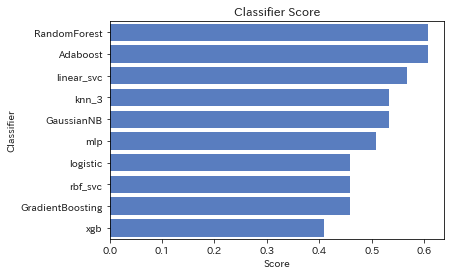

In [54]:
# 評価指標はaccuracy_scoreにしました。
model_selection(X, y, accuracy_score)

In [55]:
scl = StandardScaler()
X = scl.fit_transform(X)
model = RandomForestClassifier(random_state=0)
model.fit(X, y)
model.predict(X)

array([1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])

In [56]:
X_fin = dft.iloc[-1, :-1].values.reshape(-1, 1).T

In [57]:
model.predict(X_fin)

array([0.])

これを、stock_selectにある株の分である34回行い、ラベルとして1がついたものを選びました。<br>
それが10個出てきたのですが、そこから2018年の7、8月に急激に株価が上がっていた銘柄を除いた6個を最終的にポートフォリオとして提出しました。<br>
34個同じ処理をここに書くのは冗長なので省きます。